Notebook to compare dirty images against the sky model and check signs and conjugations:
 - read an AAVS HDF5 data file and a station YAML file,
 - run ska-low-mccs-calibration calibration
 - plot the pyGDSM sky model as a function of direction cosines from zenith
 - image the calibrated data and plot it in the same way

It requires local copies of the HDF5, YAML and EEP files.
EEP files should be converted to .npy format as described in:<br>
https://developer.skatelescope.org/projects/ska-low-mccs-calibration/en/latest/sky-models.html.<br>
e.g.
    
> from ska_low_mccs_calibration.eep import convert_eep2npy<br>
> convert_eep2npy(f"/path/to/eep/data/FEKO_AAVS3_vogel_256_elem_50ohm_*MHz_?pol.mat", npy_dir="./AAVS3_EEPs_local")<br>

In [1]:
###
### Set PATHs and file names here
###

import logging
import os
import sys
import warnings

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants
from astropy.time import Time

from ska_low_mccs_calibration.calibration import calibrate_mccs_visibility
from ska_low_mccs_calibration.utils import (
    read_yaml_config,
    sdp_visibility_datamodel,
)

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

warnings.filterwarnings("ignore")

from time import perf_counter
ttotal = perf_counter()







<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__


In [2]:
# Observation date_time
date_time = "20240119_12601"

# Observation coarse channel number (obs central freq / 781.25kHz)
channel_id = 140

corr_matrix_file_PATH = '.'
corr_matrix_file = f"correlation_burst_{channel_id}_{date_time}_0.hdf5"

eep_file_path = "./AAVS3_EEPs_local"
eep_file_base = "FEKO_AAVS3_vogel_256_elem_50ohm_"

station_configuration_file = "aavs3.yaml"

# Precision to use when building models (and when converting EEP images to npy)
model_dtype = np.complex64

# HDF5 Data File

In [3]:
datafile = h5py.File(f"{corr_matrix_file_PATH}/{corr_matrix_file}", 'r')

correlation_info = datafile['observation_info']

# Get the metadata associated with the correlation matrices

correlation_metadata = dict(datafile['root'].attrs)

ntimes = correlation_metadata['n_blocks']
int_time = correlation_metadata['tsamp']
nant = correlation_metadata['n_antennas']
nbaselines = (correlation_metadata['n_baselines'])
n_pol = correlation_metadata['n_pols']
n_stokes = correlation_metadata['n_stokes']

assert nbaselines == nant * (nant + 1) // 2, "expecting all auto and cross correlations"
assert n_stokes == 4, "data should contain 4 polarisation products"
assert correlation_metadata['n_chans'] == 1, "data should have a single frequency channel"
assert correlation_metadata['channel_id'] == channel_id, f"assuming frequency channel {channel_id}"

# chop off rounding errors
int_time = round(int_time, 12)

# Get the data associated with the correlation matrices

correlation_data = np.squeeze(datafile['correlation_matrix']['data'])
print("Shape of the correlation data: ",correlation_data.shape,\
      " time_sequence, baseline_number, pol_product")

assert correlation_data.ndim == 3
assert correlation_data.shape[0] == ntimes
assert correlation_data.shape[1] == nbaselines
assert correlation_data.shape[2] == n_stokes

### Get the timestamps associated with the correlation matrices

correlation_times = datafile['sample_timestamps']
if ntimes > 1: 
    correlation_times_array = np.squeeze(correlation_times['data'])
else:
    correlation_times_array = correlation_times['data'][0]

# the first time step has lower amplitude, so drop it
correlation_times_array = correlation_times_array[1:]
correlation_data = correlation_data[1:, :, :]
ntimes = len(correlation_times_array)

print("Final shape of the correlation data: ",correlation_data.shape,\
      " time_sequence, baseline_number, pol_product")

Shape of the correlation data:  (34, 32896, 4)  time_sequence, baseline_number, pol_product
Final shape of the correlation data:  (33, 32896, 4)  time_sequence, baseline_number, pol_product


# YAML Configuration File

In [4]:
### get the antenna locations from aavs3.yaml, which is as-built

mro_site, antenna_masks, baselines, enu, pol, rotation = read_yaml_config("aavs3.yaml")

assert len(antenna_masks) == nant
assert len(baselines[0]) == nbaselines

# Convert antenna positions to numpy array for ease of use and transpose
enu = np.array(enu, dtype=model_dtype(0).real.dtype).T

# Convert yaml antenna masks to visibility masks
masked_antennas = np.where(antenna_masks==True)[0]
print("Masked antennas (zero-based indexing):", masked_antennas)

bl_flags = np.logical_or(
    np.isin(baselines[0], masked_antennas), np.isin(baselines[1], masked_antennas)
)

# May as well flag autos as well
bl_flags = np.logical_or(bl_flags, baselines[0] == baselines[1])

# stack to have the same shape as vis with common flags for XX,XY,YX,YY pol products
vis_flags = np.tile(bl_flags, (4, 1)).T

read_yaml_station: extracting station aavs3
read_yaml_config: station rotation 0.000000 deg
Masked antennas (zero-based indexing): [ 47  52  53  63  64  70  72  73  89  99 101 115 177 201 209 230]


# Package data in Visibility data model
 - https://developer.skao.int/projects/ska-sdp-datamodels/en/latest/

In [5]:
###  Package MCCS data in a ska-sdp-datamodels Visibility xarray

# Observing frequency
channel_bw_MHz = 400.0 / 512.0
frequency_MHz = float(channel_id) * channel_bw_MHz

Time_array = (Time(correlation_times_array, format='unix', location=mro_site))
Time_array.format = 'fits'

# all, average, last
time_sel = "last"
if time_sel == "average":
    # Model all separately (time consuming), model once and phase shift (should do), or just average
    time = Time_array[ntimes // 2]
    vis = sum(correlation_data) / float(ntimes)
    int_time *= ntimes
elif time_sel == "all":
    time = Time_array
    vis = correlation_data
elif time_sel == "last":
    itime = ntimes - 1
    time = Time_array[itime]
    vis = correlation_data[itime]
print(f"Selecting {int_time} seconds of data around: {time}")

v_measurement = sdp_visibility_datamodel(
    vis=vis[:, pol],
    flags=vis_flags[:, pol],
    uvw=enu[baselines[0]] - enu[baselines[1]],
    ant1=baselines[0],
    ant2=baselines[1],
    location=mro_site,
    antpos_enu=enu,
    time=time,
    int_time=int_time,
    frequency_mhz=frequency_MHz,
)

Selecting 1.98180864 seconds of data around: 2024-01-19T03:35:52.067


# Run calibration
 - Includes the generation of models visibilities from PyGDSM + solar sky models and EEP images.
 - Uses https://developer.skao.int/projects/ska-sdp-func-python/en/latest/ calibration routines.

In [6]:
# Show some extra output
log.setLevel(logging.DEBUG)

# adjust_solar_model: whether or not to refit after estimating the relative galactic and solar contribution
# jones_solve: whether or not to refit with a polarised solver

gain_table, model_vis, calibrated_vis, masked_antennas, info = calibrate_mccs_visibility(
    v_measurement,
    masked_antennas=masked_antennas,
    adjust_solar_model=True,
    jones_solve=False,
    dtype=model_dtype,
    eep_path=eep_file_path,
    eep_filebase=eep_file_base,
    eep_rotation_deg=rotation,
)

print(f"\nTotal run time: {perf_counter() - ttotal:.2f} seconds")

# update vis flags

bl_flags = np.logical_or(
    np.isin(baselines[0], masked_antennas), np.isin(baselines[1], masked_antennas)
)
bl_flags = np.logical_or(bl_flags, baselines[0] == baselines[1])

Solving for GSM with Galactic and Solar components
Selecting EEP files at 110 MHz
Complex conjugating EEP arrays
azel_to_eep_indices: EEP res: [0.500000, 0.500000] deg
predict_vis: Generating phase shifts for DFT from sky to vis
predict_vis: Resampling beam models at LSM pixel centres
azel_to_eep_indices: EEP res: [0.500000, 0.500000] deg
predict_vis: Evaluate DFT from sky to vis
GDSM DFT: 16.94 seconds
predict_vis: Generating phase shifts for DFT from sky to vis
predict_vis: Resampling beam models at LSM pixel centres
azel_to_eep_indices: EEP res: [0.500000, 0.500000] deg
predict_vis: Evaluate DFT from sky to vis
solve_gaintable: Starting calibration
solve_gaintable: Using solver gain_substitution
solve_gaintable: Solving for complex gain
solve_gaintable: Creating new gaintable
solve_gaintable: Finished calibration
Additional Antennas rejected based on low gains: [18 202]
adjust_gsm: Resetting sky model with sun * 1.62
solve_gaintable: Starting calibration
solve_gaintable: Using solve

In [7]:
# Print some of the returned QA metrics
print("correlation coeffs [XX,XY,YX,YY]:", [float(f"{x:.3f}") for x in info.corrcoeff])
print("residual vis std. dev [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info.residual_std], "K")
print("residual vis maximum [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info.residual_max], "K")
print(f"number of ant flags initial: {info.n_masked_initial}, final: {info.n_masked_final}")
print(f"xy-phase update: {info.xy_phase:.2f} deg")
print(f"solar adjustment factor: {info.sun_adjustment_factor:.3f}")
print(f"solar elevation: {info.sun_elevation:.2f} deg")
print(f"galactic centre elevation: {info.galactic_centre_elevation:.2f} deg")
print(f"LST = {info.lst:.2f} hrs")

correlation coeffs [XX,XY,YX,YY]: [0.99, 0.899, 0.902, 0.989]
residual vis std. dev [XX,XY,YX,YY]: [9.9, 7.1, 7.0, 10.5] K
residual vis maximum [XX,XY,YX,YY]: [82.8, 86.7, 60.6, 79.5] K
number of ant flags initial: 16, final: 18
xy-phase update: 176.63 deg
solar adjustment factor: 1.623
solar elevation: 77.38 deg
galactic centre elevation: 70.53 deg
LST = 19.25 hrs


# Make images

Galactic model with 1536 pixels. Sag A* elevation = 70.5325087984105 degrees
Dirty images also include the sun (not included in galactic model shown here)


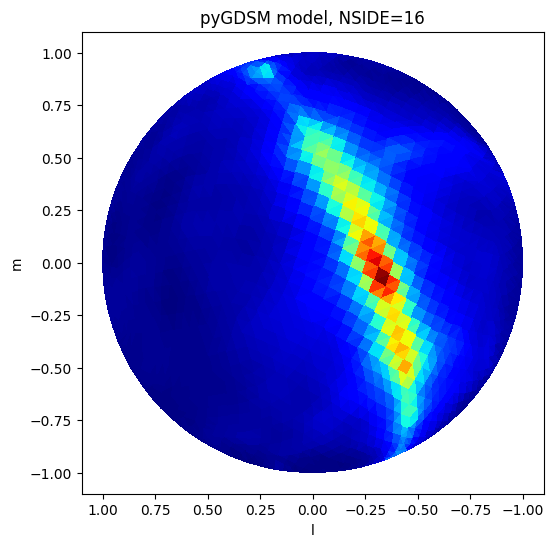

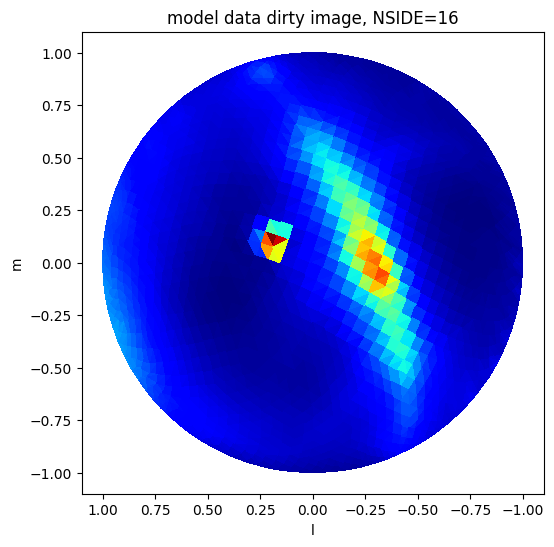

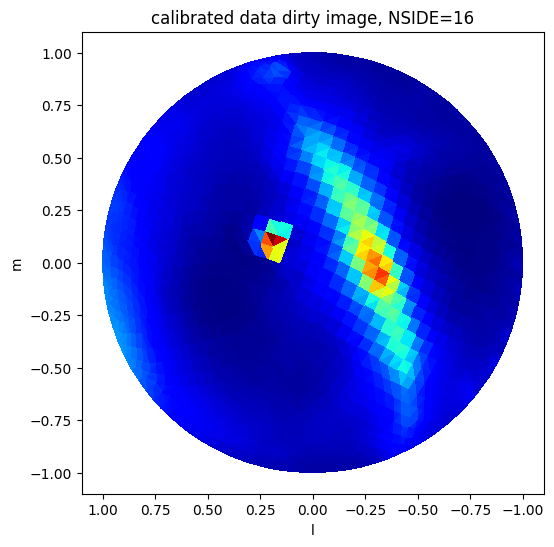

In [8]:
# Turn off debugging output before calling matplotlib tasks
log.setLevel(logging.INFO)

from ska_low_mccs_calibration.sky_model import (
    gsmap_lsm,
    gsmodel,
)
from astropy import units
from astropy.coordinates import AltAz, SkyCoord, get_sun

time = Time_array[itime] - 0 * units.hour

# low resolution sky model
nside = 16
gsmap = gsmodel(frequency_MHz, nside)[0]
location = v_measurement.configuration.location
[az_gsm, el_gsm, T_gsm] = gsmap_lsm(gsmap, location=location, time=time)
gal00 = SkyCoord(l=0.0 * units.deg, b=0.0 * units.deg, frame="galactic")
el00 = gal00.transform_to(AltAz(obstime=time, location=location)).alt.degree
print(f"Galactic model with {len(az_gsm)} pixels. Sag A* elevation = {el00} degrees")
print("Dirty images also include the sun (not included in galactic model shown here)")

# calc l,m for each pixel
l_pix = np.cos(el_gsm * np.pi/180) * np.sin(az_gsm * np.pi/180)
m_pix = np.cos(el_gsm * np.pi/180) * np.cos(az_gsm * np.pi/180)
n_pix = np.sin(el_gsm * np.pi/180)

# forward_sign should be negative
forward_sign = -1
reverse_sign = -1 * forward_sign
r2c_sign = forward_sign
c2r_sign = reverse_sign
wavelength = scipy.constants.c / frequency_MHz / 1e6
scale = c2r_sign * 2j * np.pi / wavelength
u_scl = model_vis.uvw.data[0, bl_flags==False, 0] * scale
v_scl = model_vis.uvw.data[0, bl_flags==False, 1] * scale
w_scl = model_vis.uvw.data[0, bl_flags==False, 2] * scale

# Fourier phasor with shape (nbaseline, nskypixels)
phasor = np.exp(np.outer(u_scl, l_pix) + np.outer(v_scl, m_pix) + np.outer(w_scl, n_pix))
mdl_dirty = np.real(np.einsum("b,bp->p", model_vis.vis.data[0, bl_flags==False, 0, 0], phasor))
cal_dirty = np.real(np.einsum("b,bp->p", calibrated_vis.vis.data[0, bl_flags==False, 0, 0], phasor))

# - pseudocolor plot of the pyGDSM model
plt.figure(figsize=[6, 6])
ax = plt.subplot(111, aspect="equal")
ax.invert_xaxis()
ax.set_title(f"pyGDSM model, NSIDE={nside}")
ax.set_xlabel("l")
ax.set_ylabel("m")
ax.tripcolor(l_pix, m_pix, T_gsm, cmap='jet')

# - pseudocolor plot of the model data dirty image
plt.figure(figsize=[6, 6])
ax = plt.subplot(111, aspect="equal")
ax.invert_xaxis()
ax.set_title(f"model data dirty image, NSIDE={nside}")
ax.set_xlabel("l")
ax.set_ylabel("m")
ax.tripcolor(l_pix, m_pix, mdl_dirty, cmap='jet')

# - pseudocolor plot of the calibrated data dirty image
plt.figure(figsize=[6, 6])
ax = plt.subplot(111, aspect="equal")
ax.invert_xaxis()
ax.set_title(f"calibrated data dirty image, NSIDE={nside}")
ax.set_xlabel("l")
ax.set_ylabel("m")
ax.tripcolor(l_pix, m_pix, cal_dirty, cmap='jet')